In [34]:
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib inline

In [6]:
INPUT_FOLDER = './data/sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

# Load data

The pixel size in the Z direction (slice thickness) is missing.

In [7]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

# Convert pixel value to HU

The pixels that fall outside the scan get the fixed value -2000. Set these values to 0: air. To get the HU value: multiply with the rescale slope and add the intercept.

In [24]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)

    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [11]:
first_patient = load_scan(INPUT_FOLDER + patients[1])

In [25]:
first_patient_pixels = get_pixels_hu(first_patient)

# Plot the image histogram and some slice

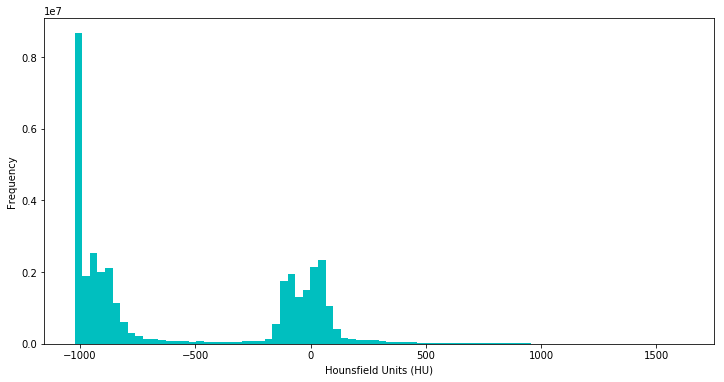

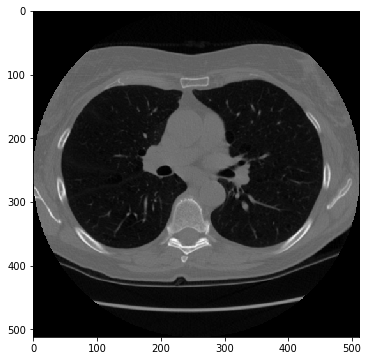

In [31]:
# plt.figure(figsize=(width, height))
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# plt.figure(figsize=(width, height))
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

# Resample
Scans can have different spacings: [2.5, 0.5, 0.5] or [1.5, 0.725, 0.725]. That is 2.5 mm for the forst former and 1.5 mm for the latter. We convert the scans to an isotropic resolution: [1, 1, 1].

In [32]:
def resample(image, scan, new_spacing=[1,1,1]):
    # current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [33]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (335, 306, 306)


# Print 3D image

In [35]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

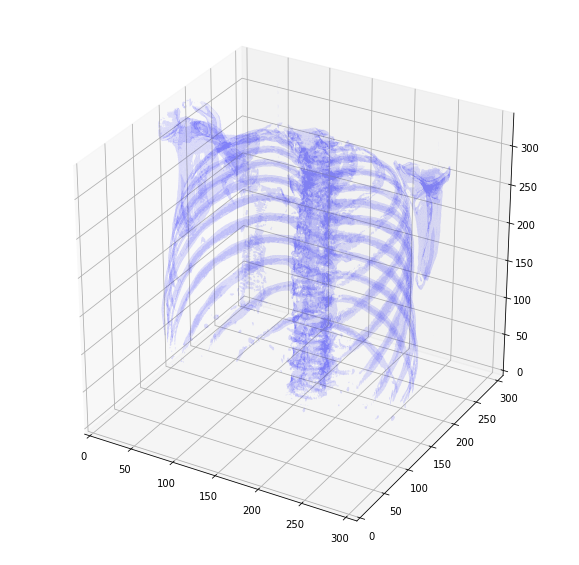

In [36]:
plot_3d(pix_resampled, 400)